# Calibrating the cloud clearing algorithm
The goal with the cloud clearing algorithm is to filter out areas where the cloud cover is too thick for any ice to be retrieved. This is a two-step process with multiple adjustable parameters: first all cloudy pixels are selected and added to the mask, then cloudy pixels that are likely to have visible ice are removed from the mask. Both steps use thresholds for intensity values channel 1 and channel 2 of the MODIS false color imagery. 

Let the intensity value of channel $i$ be given by $l_i$. The module then creates a binary mask with the following steps:
1. Mask all pixels with $l_1 > 110 = T_C$.
2. Unmask pixels with $l_1 < 200 = T_1$ and $l_2 > 190 = T_2$.
3. Unmask pixels with $l_1/l_2 < 0.75 = R_{1,2}$.

We evaluate the algorithm in two parts. First, we search for an optimum value for the cloud threshold $T_C$. Presently, the manual estimate of cloud fraction is our best estimate of the "truth" for the total cloud fraction $F$. The fraction of pixels with $l_1 > T_C$ is the estimated total cloud fraction $\hat{F}$. We select 2/3 of the data at random as the training dataset. To this subset, we apply $k$-fold cross validation, optimizing the choice of cloud threshold across $T_C = 0, 10, 20, \cdots, 200$. After computing RMSE for each choice of $T_C$, we find a best-fit quadratic interpolant and find the minimizing integer value of $T_C$. The optimal choice of $T_C$ is the average across the $k$ folds. We also report the mean $RMSE$ across the $k$ $T_C$ estimates. Finally, we calculate the error in the cloud fraction relative to the remaining 1/3 of the data.

In [29]:
import numpy as np
import os
import pandas as pd
import proplot as pplt
import rasterio as rio
from rasterio.plot import reshape_as_image
from sklearn.model_selection import KFold
from scipy.interpolate import interp1d

# Load the list of cloud clearing evaluation cases
df = pd.read_csv('../data/validation_tables/qualitative_assessment_tables/all_100km_cases.csv', index_col='case_number')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [30]:
df['start_date'] = pd.to_datetime(df['start_date'].values)
df['case_number'] = [str(x).zfill(3) for x in df.index]
df.index = [cn + '_' + sat for cn, sat in zip(df.case_number, df.satellite)]

def fname(case_data, imtype='labeled'):
    """Generates filenames from rows in the overview table. imtype can be "labeled", "truecolor", 
    or "falsecolor"."""

    cn = case_data['case_number']
    date = pd.to_datetime(case_data['start_date']).strftime('%Y%m%d')
    region = case_data['region']
    sat = case_data['satellite']
    if imtype=='labeled':
        prefix = '_'.join([cn, region, date])
        return prefix + '_' + sat + '.tiff'
        
    elif imtype in ['truecolor', 'falsecolor']:
        prefix = '_'.join([cn, region, '100km', date])
        return '.'.join([prefix, sat, imtype, '250m', 'tiff'])

In [31]:
# Load raster data
fc_dataloc = '../data/validation_images/falsecolor/'
tc_dataloc = '../data/validation_images/truecolor/'
lb_dataloc = '../data/validation_images/labeled_floes_gtiff/'

fc_images = {}
tc_images = {}
lb_images = {}

labeled = [l.split('_')[0] + '_' + l.split('_')[-1].replace('.tiff', '')
           for l in os.listdir(lb_dataloc) if l != '.DS_Store']
missing = []
for case in df.loc[df.cloud_fraction.notnull(),:].index:
    for dataloc, imtype, data_dict in zip([fc_dataloc, tc_dataloc],
                                          ['falsecolor', 'truecolor'],
                                          [fc_images, tc_images]):
        try:
            with rio.open(dataloc + fname(df.loc[case,:], imtype)) as im:
                data_dict[case] = im.read()
        except:
            print('Couldn\'t read', fname(df.loc[case,:], imtype))
            if case not in missing:
                missing.append(case)

for case in labeled:
    try:
        with rio.open(lb_dataloc + fname(df.loc[case,:], 'labeled')) as im:
            lb_images[case] = im.read()
    except:
        print('Couldn\'t read', fname(df.loc[case,:], imtype))
        if case not in missing:
            missing.append(case)        

Couldn't read 134_beaufort_sea_100km_20170925.aqua.falsecolor.250m.tiff


/opt/miniconda3/envs/cal-val/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Couldn't read 334_hudson_bay_100km_20170716.terra.falsecolor.250m.tiff


In [32]:
# Drop case with missing falsecolor image
df = df.drop(missing, axis=0)

In [33]:
# Compute estimated cloud fraction for a range of threshold values
cloud_cases = df.dropna(subset='cloud_fraction').index
TC = np.linspace(0, 200, 21)
df_est_tc = pd.DataFrame(index=cloud_cases,
                          columns=TC, data=np.nan)
# for each value, compute an estimated cloud fraction based on the fc_images
for tc in df_est_tc.columns:
    for case in df_est_tc.index:
        df_est_tc.loc[case, tc] = np.mean(fc_images[case][0,:,:] > tc)

# finally, calculate the difference between F and F_est
df_err = (df_est_tc.T - df.loc[cloud_cases, 'cloud_fraction']).T

In [36]:
df_training = df_err.sample(frac=2/3, replace=False, random_state=306)
df_testing = df_err.loc[[x for x in df_err.index if x not in df_training.index]]

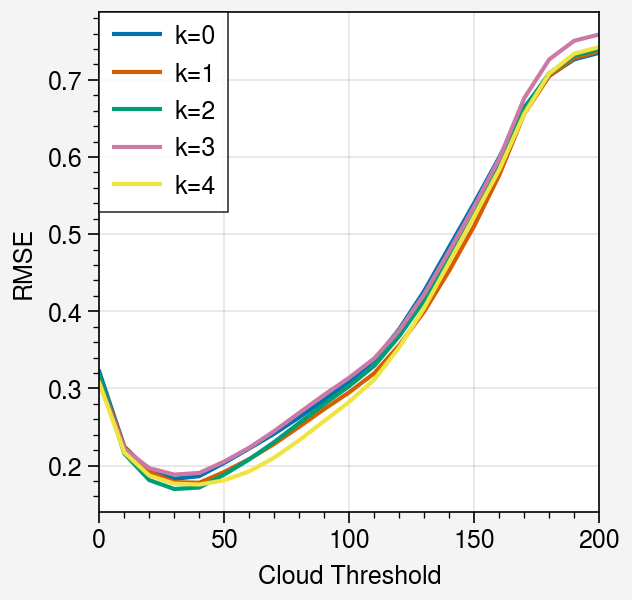

In [38]:
# Test version without splitting by regions to get syntax
fig, ax = pplt.subplots()
x_eval = np.linspace(TC.min(), TC.max(), 201)
results = []

# Initialize cross validation
# TBD: learn how to stratify within the K-fold samplng
kf = KFold(n_splits=5, random_state=20240126, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(df_training)):
    # first get the root mean square error as a function of TC
    rmse = np.sqrt(np.mean( df_training.iloc[train_index,:]**2, axis=0))
    
    # then find the minimum
    tc_optimal = pd.Series(interp1d(x=rmse.index, y=rmse.values, kind='quadratic')(x_eval), index=x_eval).idxmin()

    test_cases = df_training.iloc[test_index, :].index
    test_results = np.array([
        np.mean(fc_images[case][0,:,:] > tc_optimal) - df.loc[case, 'cloud_fraction']
            for case in test_cases])
    tc_rmse = np.sqrt(np.mean(test_results**2))
    results.append([tc_optimal, tc_rmse])
    
    ax.plot(rmse, label='k=' + str(i))
ax.format(ylabel='RMSE', xlabel='Cloud Threshold')
ax.legend(loc='ul', ncols=1)

In [39]:
kfold_results = pd.DataFrame(results, columns=['TC', 'RMSE'])
kfold_results

,TC,RMSE
0,33.0,0.161109
1,36.0,0.186763
2,34.0,0.212251
3,33.0,0.134484
4,36.0,0.192209


In [40]:
kfold_results.mean(axis=0).round(2)

TC      34.40
RMSE     0.18
dtype: float64

In [49]:
# Error against the held-out data
tc = 34
test_results = np.array([
    np.mean(fc_images[case][0,:,:] > tc) - df.loc[case, 'cloud_fraction']
        for case in df_testing.index])
test_results = pd.Series(test_results, index=df_testing.index)
tc_rmse = np.sqrt(np.mean(test_results**2))
print('CF error:', np.round(tc_rmse, 3))

CF error: 0.181


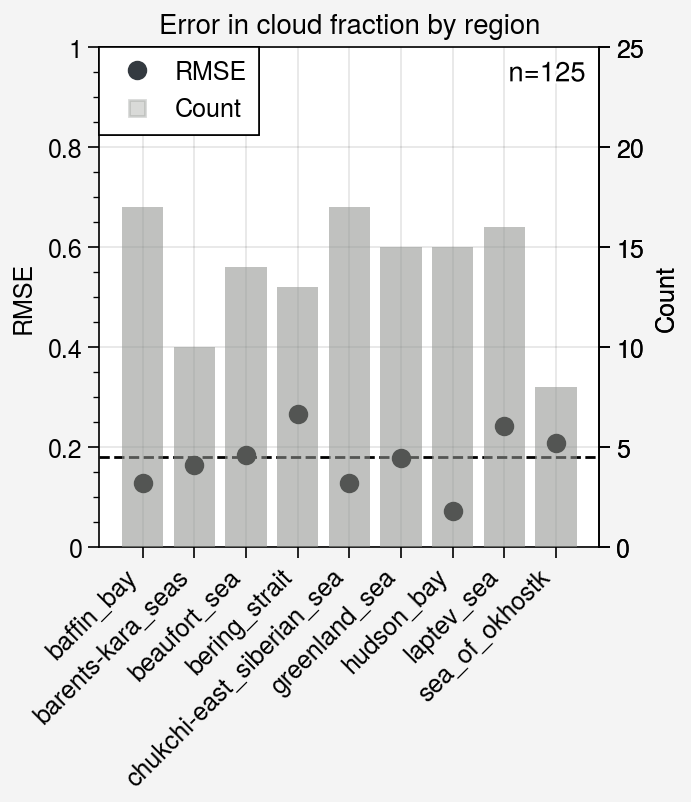

In [80]:
fig, ax = pplt.subplots()
ax.plot(
    test_results.groupby(df.loc[test_results.index, 'region']).apply(lambda x: np.sqrt(np.mean(x**2))),
    marker='o', lw=0, zorder=2, color='k')
ax2 = ax.twinx()
ax2.bar(
    test_results.groupby(df.loc[test_results.index, 'region']).count(), zorder=0, color='gray', alpha=0.35
    )
ax2.format(ylabel='Count', ytickminor=False)

ax.format(xrotation=45, ylim=(0, 1), xlabel='', ylabel='RMSE', title='Error in cloud fraction by region')
ax.format(urtitle='n=' + str(len(test_results)))
ax2.format(ylim=(0, 25))
h = [ax.plot([],[],marker='o', color='gray8', lw=0),
     ax.plot([],[],marker='s', color='gray', alpha=0.35, lw=0)]
ax2.legend(h, ['RMSE', 'Count'], loc='ul', ncols=1, alpha=1)
ax.axhline(tc_rmse, color='k', ls='--', lw=1)

# Results
Based on the manual cloud fraction data, the optimal choice of the cloud threshold $T_C$ is 34, with an associated error of 18%. The visualization of the RMSE function for the 5-fold cross validation shows that the threshold choice varies only slightly between samples, and that the variability in RMSE abetween regions is note particularly large. 

# Questions
- Is it better to over or underestimate cloud fraction?
- Is this low threshold overly aggressive?
- How does the error look spatially?
- How does the manual cloud fraction compare to the MODIS cloud mask, which is likely more precise?
- How does the manual cloud fraction compare with ERA5, CERES cloud fractions? (e.g.)
- Can I wrap together the parts of the k-fold validation using cleaner arrangements? E.g. using recommended functions from the docs.
- Is there a tendency toward a particular kind of error w/ e.g. thin clouds, land, different cloud fractions?

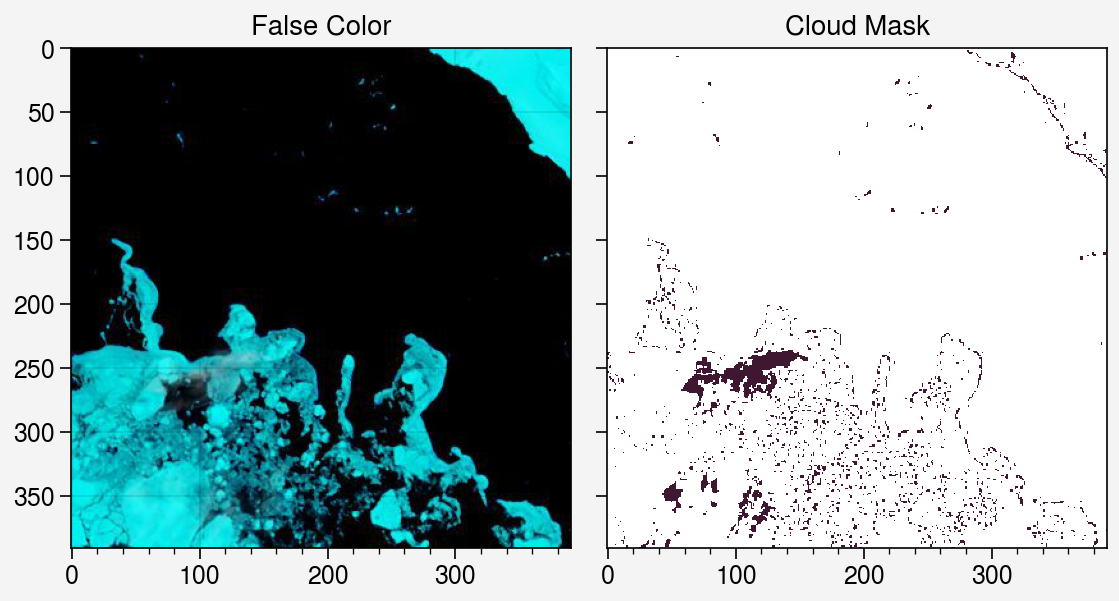

In [104]:
from rasterio.plot import reshape_as_image
fig, ax = pplt.subplots(ncols=2)
case = '050_aqua'
ax[0].imshow(reshape_as_image(fc_images[case]))
ax[1].pcolormesh((fc_images[case][0,:,:] > tc).astype(int)) 
ax.format(ytickminor=False)
ax[0].format(title='False Color')
ax[1].format(title='Cloud Mask')